In [0]:
import tensorflow as tf

from tensorflow.python.keras.applications.vgg19 import VGG19

In [2]:
model = VGG19(
    include_top = False,
    weights = 'imagenet'
)

model.trainable = False

model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [0]:
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Image Processing and Display

In [0]:
def load_and_process_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img,axis=0)
    return img

In [0]:
def deprocess(x):
    x[:,:, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    x = x[:,:,::-1]
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_image(image):
    if len(image.shape) == 4:
        img = np.squeeze(image, axis = 0)
        
    img = deprocess(img)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

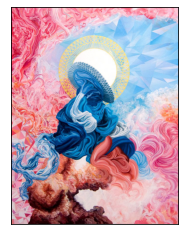

In [6]:
display_image(load_and_process_image('Style.jpg'))

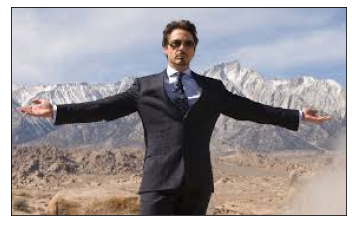

In [7]:
display_image(load_and_process_image('Content.png'))

## Content and Style Models

In [0]:
content_layer = 'block5_conv2'

style_layers = ['block1_conv1','block3_conv1','block5_conv1']

content_model = Model(
    inputs = model.input,
    outputs = model.get_layer(content_layer).output
)

style_models = [Model(inputs = model.input,
                     outputs = model.get_layer(layer).output) for layer in style_layers]

## Content Cost

In [0]:
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    cost = tf.reduce_mean(tf.square(a_C - a_G))
    return cost

## Gram Matrix

In [0]:
def gram_matrix(A):
    n_C = int(A.shape[-1])
    a = tf.reshape(A, [-1, n_C])
    n = tf.shape(a)[0]
    G = tf.matmul(a, a, transpose_a = True)
    return G/tf.cast(n, tf.float32)

## Style Cost

In [0]:
lam = 1./len(style_models)

def style_cost(style, generated):
    J_style = 0
    
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS  = gram_matrix(a_S)
        GG  = gram_matrix(a_G)
        
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        
        J_style += current_cost * lam
    return J_style

## Training

In [0]:
import time

generated_images = []

def training_loop(content_path, style_path, iterations = 20, alpha=10., beta = 20.):
    
    content = load_and_process_image(content_path)
    style   = load_and_process_image(style_path)
    
    generated = tf.Variable(content, dtype=tf.float32)
    
    opt = tf.compat.v1.train.AdamOptimizer(learning_rate = 7.)
    
    best_cost = None
    best_image = None
    
    start_time = time.time()
    
    for i in range(iterations):
        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_total = alpha*J_content + beta*J_style
            
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])
        
        if best_cost is None:
          best_cost = J_total

        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
            
        print("cost at {}: {}. Time elapsed: {}".format(i+1, J_total, time.time()-start_time))
        generated_images.append(generated.numpy())
        
    return best_image

In [14]:
best_image = training_loop('Content.png', 'Style.jpg', iterations=40)

cost at 1: 3250503680.0. Time elapsed: 13.104000568389893
cost at 2: 1580652672.0. Time elapsed: 13.867000818252563
cost at 3: 1465975808.0. Time elapsed: 14.635051727294922
cost at 4: 1004715328.0. Time elapsed: 15.406155586242676
cost at 5: 732266624.0. Time elapsed: 16.174917221069336
cost at 6: 611718976.0. Time elapsed: 16.948025226593018
cost at 7: 484979872.0. Time elapsed: 17.773381233215332
cost at 8: 401276832.0. Time elapsed: 18.54491353034973
cost at 9: 379657664.0. Time elapsed: 19.322454929351807
cost at 10: 333815776.0. Time elapsed: 20.096697330474854
cost at 11: 280166176.0. Time elapsed: 20.874027490615845
cost at 12: 245454176.0. Time elapsed: 21.6459219455719
cost at 13: 219285760.0. Time elapsed: 22.426971435546875
cost at 14: 196932464.0. Time elapsed: 23.204028844833374
cost at 15: 178832144.0. Time elapsed: 23.980024576187134
cost at 16: 165879456.0. Time elapsed: 24.75690197944641
cost at 17: 151684928.0. Time elapsed: 25.536056995391846
cost at 18: 134596736.0

##Results

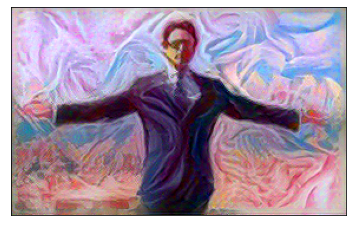

In [15]:
display_image(best_image)

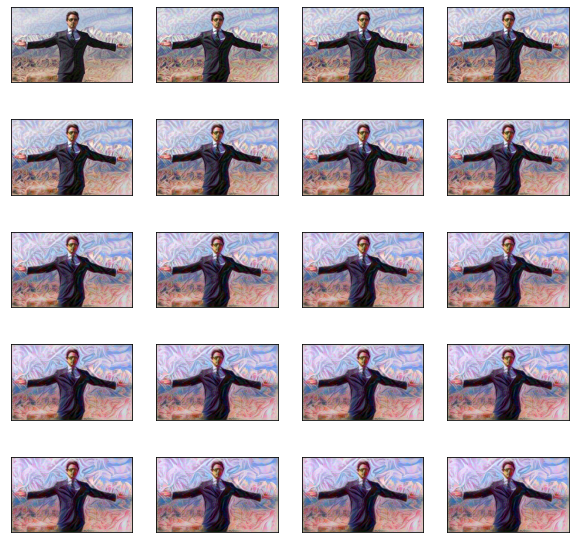

In [16]:
plt.figure(figsize=(10,10))

for i in range(20):
  # plt.subplots(5, 4)
  plt.subplot(5, 4, 1+i)
  display_image(generated_images[i])

plt.show()

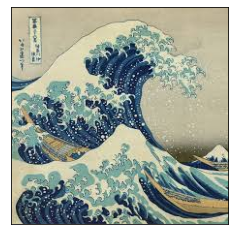

In [17]:
display_image(load_and_process_image('Style_1.png'))

In [18]:
best_image = training_loop('Content.png', 'Style_1.png')

cost at 1: 5467479040.0. Time elapsed: 1.7497148513793945
cost at 2: 2896472832.0. Time elapsed: 1.9302656650543213
cost at 3: 1749156480.0. Time elapsed: 2.1147801876068115
cost at 4: 1714957312.0. Time elapsed: 2.29982852935791
cost at 5: 1165750528.0. Time elapsed: 2.485142946243286
cost at 6: 857412800.0. Time elapsed: 2.675985336303711
cost at 7: 731695488.0. Time elapsed: 2.857722520828247
cost at 8: 636022720.0. Time elapsed: 3.038482427597046
cost at 9: 565300352.0. Time elapsed: 3.221113681793213
cost at 10: 505043264.0. Time elapsed: 3.4017820358276367
cost at 11: 438179168.0. Time elapsed: 3.583936929702759
cost at 12: 383379200.0. Time elapsed: 3.765465021133423
cost at 13: 346073856.0. Time elapsed: 3.9477310180664062
cost at 14: 314215264.0. Time elapsed: 4.129826068878174
cost at 15: 284423072.0. Time elapsed: 4.312160015106201
cost at 16: 261123456.0. Time elapsed: 4.500087738037109
cost at 17: 242395456.0. Time elapsed: 4.6820292472839355
cost at 18: 224111824.0. Time 

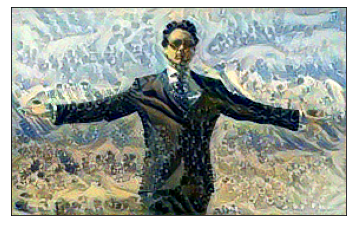

In [19]:
display_image(best_image)